# Expedia Hotel Recommendation

Data Description

Expedia has provided you logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. The data in this competition is a random selection from Expedia and is not representative of the overall statistics.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

Your goal of this competition is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.

The train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015. The public/private leaderboard data are split base on time as well. Training data includes all the users in the logs, including both click events and booking events. Test data only includes booking events. 

destinations.csv data consists of features extracted from hotel reviews text. 

Note that some srch_destination_id's in the train/test files don't exist in the destinations.csv file. This is because some hotels are new and don't have enough features in the latent space. Your algorithm should be able to handle this missing information.

In [2]:
# train/test.csv

# date_time(string) : Timestamp 
# site_name(int) : ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...)
# posa_continent(int) : ID of continent associated with site_name
# user_location_country(int) : The ID of the country the customer is located
# user_location_region(int) : The ID of the region the customer is located
# user_location_city(int) : The ID of the city the customer is located
# orig_destination_distance(double) : Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated	double
# user_id(int) : ID of user
# is_mobile(tinyint) : 1 when a user connected from a mobile device, 0 otherwise
# is_package(int) : 1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise
# channel(int) : ID of a marketing channel
# srch_ci(string) : Checkin date
# srch_co(string) : Checkout date
# srch_adults_cnt(int) : The number of adults specified in the hotel room
# srch_children_cnt(int) : The number of (extra occupancy) children specified in the hotel room
# srch_rm_cnt(int) : The number of hotel rooms specified in the search
# srch_destination_id(int) : ID of the destination where the hotel search was performed
# srch_destination_type_id(int) : Type of destination
# hotel_continent(int) : Hotel continent
# hotel_country(int) : Hotel country
# hotel_market(int) : Hotel market
# is_booking(tinyint) : 1 if a booking, 0 if a click
# cnt(bigint) : Numer of similar events in the context of the same user session
# hotel_cluster(int) : ID of a hotel cluster

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import missingno as msno
import ml_metrics as metrics

In [4]:
destinations = pd.read_csv("destinations.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

### Check Dataset

In [5]:
print('destinations.shape', destinations.shape)

destinations.shape (62106, 150)


In [6]:
print('train.shape :', train.shape)
print('test.shape :', test.shape)

train.shape : (37670293, 24)
test.shape : (2528243, 22)


- train set 너무 많음 --> 이대로 계속 분석 가능한지?(메모리 이슈)

In [7]:
# check including missing values
# destinations.head()
destinations.tail() 

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
62101,64989,-2.145876,-2.158016,-2.216621,-2.158016,-2.006209,-2.102505,-2.216621,-2.157203,-2.216621,...,-2.216621,-2.158016,-2.158016,-2.216621,-2.216621,-2.216621,-2.216621,-2.216621,-2.216621,-2.152024
62102,64990,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.176802,-2.203479,-2.203479,-2.203479,...,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.008885
62103,64991,-2.190567,-2.208308,-2.208308,-2.208308,-2.208308,-2.135493,-2.208308,-2.208308,-1.909808,...,-2.188935,-2.208308,-2.175594,-2.208308,-2.208308,-2.199347,-2.208308,-2.208308,-2.208308,-2.208308
62104,64992,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,...,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686
62105,64993,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,...,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457


- row index와 srch_destination_id가 차이나는 것으로 보아, missing된 id가 많이 존재하는 것으로 판단 -> 어떻게 처리할지?

In [8]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


- 대부분 integer, float variable
- date time는 유용한 피처이므로, format 변경 필요
- user_loaction_country, user_location_city의 정확한 의미 알 수 없어 사용이 어려워 보임
- orig_destination_distance Nan 어떻게 처리할지?

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37670293 entries, 0 to 37670292
Data columns (total 24 columns):
date_time                    object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                      object
srch_co                      object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
is_booking                   int64
cnt                          int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
hotel_cluster                int64
dtypes: float64(1), int64(20), object(3)

In [10]:
test.head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528243 entries, 0 to 2528242
Data columns (total 22 columns):
id                           int64
date_time                    object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                      object
srch_co                      object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
dtypes: float64(1), int64(18), object(3)
memory usage: 424.4+ MB


In [12]:
train.describe()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,2.414529e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,...,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07
mean,9.795271e+00,2.680473e+00,8.610880e+01,3.084060e+02,2.775304e+04,1.970090e+03,6.044518e+05,1.349265e-01,2.489042e-01,5.870761e+00,...,3.321222e-01,1.112663e+00,1.444109e+04,2.582280e+00,7.965675e-02,1.483384e+00,3.156305e+00,8.129685e+01,6.004619e+02,4.980861e+01
std,1.196754e+01,7.480393e-01,5.924310e+01,2.084437e+02,1.678255e+04,2.232442e+03,3.506175e+05,3.416451e-01,4.323782e-01,3.717095e+00,...,7.314981e-01,4.591155e-01,1.106630e+04,2.153019e+00,2.707611e-01,1.219776e+00,1.623189e+00,5.617119e+01,5.117391e+02,2.891595e+01
min,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.600000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.000000e+00,6.600000e+01,1.740000e+02,1.300900e+04,3.131670e+02,2.989100e+05,0.000000e+00,0.000000e+00,2.000000e+00,...,0.000000e+00,1.000000e+00,8.267000e+03,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+01,1.600000e+02,2.500000e+01
50%,2.000000e+00,3.000000e+00,6.600000e+01,3.140000e+02,2.765500e+04,1.140491e+03,6.039140e+05,0.000000e+00,0.000000e+00,9.000000e+00,...,0.000000e+00,1.000000e+00,9.147000e+03,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+01,5.930000e+02,4.900000e+01
75%,1.400000e+01,3.000000e+00,7.000000e+01,3.850000e+02,4.241300e+04,2.552599e+03,9.101680e+05,0.000000e+00,0.000000e+00,9.000000e+00,...,0.000000e+00,1.000000e+00,1.879000e+04,5.000000e+00,0.000000e+00,2.000000e+00,4.000000e+00,1.060000e+02,7.010000e+02,7.300000e+01
max,5.300000e+01,4.000000e+00,2.390000e+02,1.027000e+03,5.650800e+04,1.240790e+04,1.198785e+06,1.000000e+00,1.000000e+00,1.000000e+01,...,9.000000e+00,8.000000e+00,6.510700e+04,9.000000e+00,1.000000e+00,2.690000e+02,6.000000e+00,2.120000e+02,2.117000e+03,9.900000e+01


In [13]:
test.describe()

,id,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
count,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,1.680782e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06
mean,1.264121e+06,9.709666e+00,2.697413e+00,8.551612e+01,3.170341e+02,2.786218e+04,1.686398e+03,6.026459e+05,1.425978e-01,1.093253e-01,6.493726e+00,1.958127e+00,2.507413e-01,1.117410e+00,1.656862e+04,2.941702e+00,3.022615e+00,8.125454e+01,6.464926e+02
std,7.298410e+05,1.227183e+01,7.651288e-01,5.673880e+01,2.082834e+02,1.668788e+04,2.197361e+03,3.469651e+05,3.496623e-01,3.120470e-01,3.931422e+00,8.980415e-01,6.754566e-01,4.615010e-01,1.280502e+04,2.282006e+00,1.674879e+00,5.507528e+01,5.046530e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.600000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.320605e+05,2.000000e+00,3.000000e+00,6.600000e+01,1.740000e+02,1.354200e+04,2.080691e+02,3.020785e+05,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,8.267000e+03,1.000000e+00,2.000000e+00,5.000000e+01,2.750000e+02
50%,1.264121e+06,2.000000e+00,3.000000e+00,6.600000e+01,3.180000e+02,2.765500e+04,7.278764e+02,6.041940e+05,0.000000e+00,0.000000e+00,9.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.201200e+04,1.000000e+00,2.000000e+00,5.000000e+01,6.280000e+02
75%,1.896182e+06,1.300000e+01,3.000000e+00,6.900000e+01,3.980000e+02,4.232800e+04,2.222729e+03,9.038295e+05,0.000000e+00,0.000000e+00,1.000000e+01,2.000000e+00,0.000000e+00,1.000000e+00,2.354100e+04,6.000000e+00,4.000000e+00,1.050000e+02,7.830000e+02
max,2.528242e+06,5.300000e+01,4.000000e+00,2.390000e+02,1.027000e+03,5.650900e+04,1.220623e+04,1.198785e+06,1.000000e+00,1.000000e+00,1.000000e+01,9.000000e+00,9.000000e+00,8.000000e+00,6.578000e+04,9.000000e+00,6.000000e+00,2.120000e+02,2.117000e+03


In [14]:
print(len(train.columns), train.columns)
print(len(test.columns), test.columns)

24 Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')
22 Index(['id', 'date_time', 'site_name', 'posa_continent',
       'user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'hotel_continent', 'hotel_country', 'hotel_market'],
      dtype='object')


### Check null data 

In [15]:
for col in train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (train[col].isnull().sum() / train[col].shape[0]))
    print(msg)

column:  date_time	 Percent of NaN value: 0.00%
column:  site_name	 Percent of NaN value: 0.00%
column: posa_continent	 Percent of NaN value: 0.00%
column: user_location_country	 Percent of NaN value: 0.00%
column: user_location_region	 Percent of NaN value: 0.00%
column: user_location_city	 Percent of NaN value: 0.00%
column: orig_destination_distance	 Percent of NaN value: 35.90%
column:    user_id	 Percent of NaN value: 0.00%
column:  is_mobile	 Percent of NaN value: 0.00%
column: is_package	 Percent of NaN value: 0.00%
column:    channel	 Percent of NaN value: 0.00%
column:    srch_ci	 Percent of NaN value: 0.12%
column:    srch_co	 Percent of NaN value: 0.12%
column: srch_adults_cnt	 Percent of NaN value: 0.00%
column: srch_children_cnt	 Percent of NaN value: 0.00%
column: srch_rm_cnt	 Percent of NaN value: 0.00%
column: srch_destination_id	 Percent of NaN value: 0.00%
column: srch_destination_type_id	 Percent of NaN value: 0.00%
column: is_booking	 Percent of NaN value: 0.00%
col

- ID 없음
- orig_destination_distance 없는 것이 존재 (by data description)
- checkin/checkout missing value 존재

In [16]:
Nan_ci_idx = list(train.loc[train['srch_ci'].isnull()]['srch_ci'].index)
Nan_co_idx = list(train.loc[train['srch_co'].isnull()]['srch_co'].index)
print(len(Nan_ci_idx))
print(len(Nan_co_idx))

equal_idx = 0
for i in range(len(Nan_ci_idx)):
    if Nan_ci_idx[i] in Nan_co_idx:
        equal_idx += 1

print(equal_idx)

47083
47084
47079


- Checkin data와 Checkout data의 누락이 대부분 겹치치만, 각각 누락된 것도 있음

In [17]:
for col in test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (test[col].isnull().sum() / test[col].shape[0]))
    print(msg)

column:         id	 Percent of NaN value: 0.00%
column:  date_time	 Percent of NaN value: 0.00%
column:  site_name	 Percent of NaN value: 0.00%
column: posa_continent	 Percent of NaN value: 0.00%
column: user_location_country	 Percent of NaN value: 0.00%
column: user_location_region	 Percent of NaN value: 0.00%
column: user_location_city	 Percent of NaN value: 0.00%
column: orig_destination_distance	 Percent of NaN value: 33.52%
column:    user_id	 Percent of NaN value: 0.00%
column:  is_mobile	 Percent of NaN value: 0.00%
column: is_package	 Percent of NaN value: 0.00%
column:    channel	 Percent of NaN value: 0.00%
column:    srch_ci	 Percent of NaN value: 0.00%
column:    srch_co	 Percent of NaN value: 0.00%
column: srch_adults_cnt	 Percent of NaN value: 0.00%
column: srch_children_cnt	 Percent of NaN value: 0.00%
column: srch_rm_cnt	 Percent of NaN value: 0.00%
column: srch_destination_id	 Percent of NaN value: 0.00%
column: srch_destination_type_id	 Percent of NaN value: 0.00%
col

- test set은 missing value 없음
- is_booking, cnt, hotel_cluster(label) column 없음

In [18]:
# msno.bar(df=train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.matrix(df=train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

In [19]:
# msno.bar(df=test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.matrix(df=test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

### Check target label

In [20]:
train['hotel_cluster'].value_counts()

91    1043720
41     772743
48     754033
64     704734
65     670960
       ...   
35     139122
53     134812
88     107784
27     105040
74      48355
Name: hotel_cluster, Length: 100, dtype: int64

48355 1043720


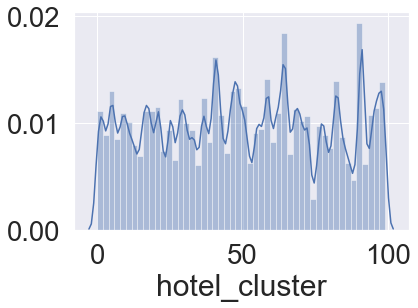

In [21]:
sns.distplot(train['hotel_cluster'])
print(min(train['hotel_cluster'].value_counts()), max(train['hotel_cluster'].value_counts()))

### Convert Dates to Year & Month for original Train set

In [22]:
# train['date_time'] = pd.to_datetime(train['date_time'])
# train['year'] = train['date_time'].dt.year
# train['month'] = train['date_time'].dt.month
# train['day'] = train['date_time'].dt.day
# train.head()

### Downsizing dataset (by Random sampling)

In [23]:
userid_group = train.groupby(['user_id'])['hotel_cluster'].value_counts()
print(userid_group)
print('unique user count :',train['user_id'].nunique())

user_id  hotel_cluster
0        19               1
         28               1
         40               1
         56               1
         72               1
                         ..
1198784  79               2
         26               1
         68               1
         95               1
1198785  76               2
Name: hotel_cluster, Length: 14865110, dtype: int64
unique user count : 1198786


- 1,198,786개 -> 100,000개 random sampling

In [25]:
unique_user_set = set(train['user_id'].unique())
sampling_user_set = random.sample(unique_user_set, 40000)

train_sampling = pd.DataFrame()
train_chunking = pd.read_csv('train.csv', chunksize = 100000)

for c in train_chunking:
    train_sampling = train_sampling.append(c.loc[c['user_id'].isin(sampling_user_set)])

print('sampling unique user count :',train_sampling['user_id'].nunique())    

sampling unique user count : 40000


In [26]:
train_sampling['date_time'] = pd.to_datetime(train_sampling['date_time'])
train_sampling['year'] = train_sampling['date_time'].dt.year
train_sampling['month'] = train_sampling['date_time'].dt.month
train_sampling['day'] = train_sampling['date_time'].dt.day
train_sampling.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,day
5185,2013-04-11 12:10:21,2,3,66,174,18354,83.2392,32458,0,0,...,6,0,1,2,50,360,48,2013,4,11
5186,2014-08-27 12:54:40,2,3,66,174,18354,40.3792,32458,0,0,...,6,0,1,2,50,358,21,2014,8,27
5187,2014-08-27 13:03:00,2,3,66,174,18354,12.9741,32458,0,0,...,1,0,1,2,50,1241,68,2014,8,27
5188,2014-08-27 13:03:32,2,3,66,174,18354,2.7224,32458,0,0,...,1,0,1,2,50,1241,40,2014,8,27
5189,2014-08-27 13:04:21,2,3,66,174,18354,4.7195,32458,0,0,...,1,0,1,2,50,1241,68,2014,8,27


In [28]:
train_sampling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1264895 entries, 5185 to 37670214
Data columns (total 27 columns):
date_time                    1264895 non-null datetime64[ns]
site_name                    1264895 non-null int64
posa_continent               1264895 non-null int64
user_location_country        1264895 non-null int64
user_location_region         1264895 non-null int64
user_location_city           1264895 non-null int64
orig_destination_distance    803698 non-null float64
user_id                      1264895 non-null int64
is_mobile                    1264895 non-null int64
is_package                   1264895 non-null int64
channel                      1264895 non-null int64
srch_ci                      1263218 non-null object
srch_co                      1263218 non-null object
srch_adults_cnt              1264895 non-null int64
srch_children_cnt            1264895 non-null int64
srch_rm_cnt                  1264895 non-null int64
srch_destination_id          1264895 no

In [29]:
train_sampling.groupby(['year'])['month'].value_counts()

year  month
2013  7        36798
      6        34997
      8        34805
      3        34462
      4        33331
      10       32430
      5        32387
      9        31775
      2        28389
      11       27967
      12       26024
      1        25974
2014  12       99563
      7        94773
      9        91207
      10       90785
      8        88151
      11       86418
      6        74286
      5        62769
      4        59163
      3        58966
      1        40446
      2        39029
Name: month, dtype: int64

In [31]:
train_sampling.groupby(['user_id'])['hotel_cluster'].value_counts()
train_sampling.groupby(['hotel_cluster'])['user_id'].value_counts()

hotel_cluster  user_id
0              155556     55
               379144     44
               974039     41
               131190     39
               646900     38
                          ..
99             1196595     1
               1196655     1
               1197303     1
               1197832     1
               1197841     1
Name: user_id, Length: 497595, dtype: int64

### Train / Test split by train_sampling (ratio 80:20)

- month 기준으로 분할 (일 기준으로 나눌 수 있지만, 분석의 용이성을 높이고자)
- 24 month data를 8:2로 나누면, 대략 19 : 5 

In [32]:
train_new = train_sampling[((train_sampling.year == 2013) | ((train_sampling.year == 2014) & (train_sampling.month <= 7)))]
test_new = train_sampling[((train_sampling.year == 2014) & (train_sampling.month >= 8))]

In [33]:
test_new = test_new[test_new.is_booking == 1]
test_new

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,day
5194,2014-08-27 17:53:40,2,3,66,174,18354,40.3792,32458,0,0,...,6,1,1,2,50,358,21,2014,8,27
5197,2014-10-22 10:11:25,2,3,66,174,18354,40.3792,32458,0,0,...,6,1,1,2,50,358,21,2014,10,22
9661,2014-09-04 11:52:48,24,2,3,51,51906,NaN,54043,0,0,...,6,1,1,6,204,27,28,2014,9,4
10242,2014-09-13 01:48:17,2,3,70,47,14566,NaN,55121,1,0,...,1,1,1,3,182,46,46,2014,9,13
10246,2014-09-13 23:11:30,2,3,70,47,14566,NaN,55121,1,0,...,1,1,1,3,182,46,81,2014,9,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37661088,2014-10-22 21:07:27,2,3,66,153,32909,NaN,1150811,0,0,...,4,1,1,2,50,368,49,2014,10,22
37668487,2014-09-15 09:19:15,2,3,66,174,9890,2.3272,1187627,0,0,...,5,1,1,2,50,366,16,2014,9,15
37668500,2014-09-27 07:01:23,2,3,66,174,9890,1201.7666,1187627,0,0,...,1,1,1,2,50,743,48,2014,9,27
37668502,2014-09-27 11:39:14,2,3,66,174,9890,1204.5364,1187627,0,0,...,1,1,1,2,50,743,72,2014,9,27


### Feature correlation analysis

In [34]:
train.corr()['hotel_cluster']

site_name                   -0.022408
posa_continent               0.014938
user_location_country       -0.010477
user_location_region         0.007453
user_location_city           0.000831
orig_destination_distance    0.007260
user_id                      0.001052
is_mobile                    0.008412
is_package                   0.038733
channel                      0.000707
srch_adults_cnt              0.012309
srch_children_cnt            0.016261
srch_rm_cnt                 -0.005954
srch_destination_id         -0.011712
srch_destination_type_id    -0.032850
is_booking                  -0.021548
cnt                          0.002944
hotel_continent             -0.013963
hotel_country               -0.024289
hotel_market                 0.034205
hotel_cluster                1.000000
Name: hotel_cluster, dtype: float64

- hotel_cluster와 선형 상관관계가 있는 feature는 없으므로, linear regression은 적합하지 않음
- ML model을 돌리기 위한 추가 피처 고려 필요 (destination.csv)

### Additional feature generation with PCA

In [116]:
destinations.isnull().sum()

srch_destination_id    0
d1                     0
d2                     0
d3                     0
d4                     0
                      ..
d145                   0
d146                   0
d147                   0
d148                   0
d149                   0
Length: 150, dtype: int64

In [85]:
from sklearn.decomposition import PCA

pca_full = PCA(n_components=149)
destination_full_components = pca_full.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
# print('eigen_value :', pca_full.explained_variance_)
# print('explained variance ratio :', pca_full.explained_variance_ratio_)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
# print(cumsum)
dim = np.argmax(cumsum >= 0.95) + 1

print('dim over 95% :', dim)

pca = PCA(n_components=dim)

destination_compression = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(dim)]])
destination_compression = pd.DataFrame(destination_compression)
destination_compression["srch_destination_id"] = destinations["srch_destination_id"]
print('eigen_value :', pca.explained_variance_)
print('explained variance ratio :', pca.explained_variance_ratio_)

dim over 95% : 59
eigen_value : [1.33796148e-01 4.37839689e-02 1.64992509e-02 1.05243006e-02
 8.51697829e-03 7.43482719e-03 5.41283488e-03 5.00334788e-03
 4.62699828e-03 4.21918110e-03 4.02831730e-03 3.41985519e-03
 3.30528498e-03 2.74492441e-03 2.39678967e-03 2.18418613e-03
 2.08894600e-03 1.79458021e-03 1.58528393e-03 1.46633654e-03
 1.38214814e-03 1.34457526e-03 1.22998071e-03 1.14075096e-03
 9.85827897e-04 9.45535061e-04 9.04673255e-04 8.95176773e-04
 8.55647559e-04 8.42680753e-04 8.03237676e-04 7.58006761e-04
 7.29294842e-04 7.09553681e-04 6.81639308e-04 6.51588247e-04
 6.12041941e-04 5.77676406e-04 5.77381646e-04 5.19508649e-04
 4.53438583e-04 4.20811169e-04 4.18506564e-04 3.87035240e-04
 3.60449382e-04 3.52005231e-04 3.23297672e-04 2.84389756e-04
 2.58614676e-04 2.08958314e-04 2.03424998e-04 1.64575581e-04
 1.32036399e-04 1.00296024e-04 7.93844919e-05 7.18735341e-05
 6.64323696e-05 4.00736625e-05 2.64411876e-05]
explained variance ratio : [4.67277392e-01 1.52913661e-01 5.7622936

- 누적된 분산의 비율이 95%가 되도록 차원 결정

In [86]:
destination_compression.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,srch_destination_id
0,0.022853,0.159460,-0.011034,-0.124325,-0.132257,0.234054,0.028005,0.103642,-0.194373,-0.046400,...,-0.003213,-0.000788,-0.002504,0.000717,-0.000714,0.002306,0.001245,0.000026,-0.000162,0
1,-0.305368,0.099144,-0.088063,-0.034500,0.033820,0.010718,0.008793,-0.027424,-0.003951,-0.005525,...,-0.003180,0.001298,-0.000269,0.000014,0.001367,-0.000139,0.000060,0.000064,0.000022,1
2,0.031742,-0.007026,-0.014682,0.011052,0.029254,-0.161442,-0.099934,0.144827,-0.034643,-0.035606,...,-0.008582,-0.009333,-0.018241,0.012259,0.002123,-0.004599,-0.004164,0.000897,0.000622,2
3,-0.355472,-0.018649,0.012444,-0.001012,-0.016020,0.058982,0.004981,0.022259,0.002938,0.010323,...,-0.000028,-0.000498,0.001717,-0.000586,-0.000299,0.000591,-0.000484,0.000137,-0.000339,3
4,-0.141607,-0.041224,-0.004915,-0.028087,-0.039911,0.023476,0.020195,-0.003452,-0.020558,0.013322,...,-0.004149,0.001493,0.003133,-0.007264,0.006449,-0.009158,-0.009991,-0.005667,-0.001091,4


In [117]:
destination_compression.isnull().sum()

0                      0
1                      0
2                      0
3                      0
4                      0
5                      0
6                      0
7                      0
8                      0
9                      0
10                     0
11                     0
12                     0
13                     0
14                     0
15                     0
16                     0
17                     0
18                     0
19                     0
20                     0
21                     0
22                     0
23                     0
24                     0
25                     0
26                     0
27                     0
28                     0
29                     0
30                     0
31                     0
32                     0
33                     0
34                     0
35                     0
36                     0
37                     0
38                     0
39                     0


### Generate new feature

- date_time 관련 time property에 대한 피처 추가
- srch_in, srch_out 관련 date property에 대한 피처 추가
- train_sampling feature와 destinations pca 결과 feature를 concat
- train_sampling data set으로 학습

In [113]:
def gen_new_features(train_df): 
    new_features = {}
    
    # Add time feature of date_time
    kind_of_time = ["quarter", "month", "dayofweek", "day", "hour", "minute"]
    for t in kind_of_time:
        new_features[t] = getattr(train_df["date_time"].dt, t)
    
    # Add date feature of srch_ci, srch_co & 
    kind_of_date = ["month", "day", "dayofweek", "quarter"]
    for d in kind_of_date:
        new_features["ci_{0}".format(d)] = getattr(train_df["srch_ci"].dt, d)
        new_features["co_{0}".format(d)] = getattr(train_df["srch_co"].dt, d)
    new_features["duration_of_stay"] = (train_df["srch_co"] - train_df["srch_ci"]).astype('timedelta64[h]')
    
    # Add others feature
    column_others = [p for p in train_df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for c in column_others:
        new_features[c] = train_df[c]
    
    new_features_df = pd.DataFrame(new_features)
    
    # Concat destinations features
    new_features_df = new_features_df.join(destination_compression, 
                                           on="srch_destination_id", 
                                           how='left', 
                                           rsuffix="destination_compression")
    new_features_df = new_features_df.drop("srch_destination_iddestination_compression", axis=1)

    return new_features_df

train_new_feature = gen_new_features(train_sampling)
train_new_feature
# df.fillna(-1, inplace=True)

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,49,50,51,52,53,54,55,56,57,58
5185,2,4,3,11,12,10,6.0,6.0,28.0,30.0,...,0.000823,0.002018,0.000149,0.002972,-0.000159,0.000257,0.000739,-0.000168,0.000665,-0.000353
5186,3,8,2,27,12,54,8.0,9.0,29.0,1.0,...,0.004876,-0.003561,0.002685,-0.008025,-0.000871,-0.001878,-0.001699,-0.000530,-0.001157,0.001018
5187,3,8,2,27,13,3,8.0,9.0,30.0,1.0,...,0.000783,0.001409,0.007019,0.000861,-0.003482,0.005910,-0.001564,0.002586,0.006136,0.000169
5188,3,8,2,27,13,3,8.0,9.0,30.0,1.0,...,0.000783,0.001409,0.007019,0.000861,-0.003482,0.005910,-0.001564,0.002586,0.006136,0.000169
5189,3,8,2,27,13,4,8.0,9.0,30.0,1.0,...,0.000783,0.001409,0.007019,0.000861,-0.003482,0.005910,-0.001564,0.002586,0.006136,0.000169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37668875,4,11,0,25,11,34,1.0,1.0,28.0,29.0,...,0.000254,-0.001048,-0.000784,0.000778,-0.001442,-0.000448,0.000421,-0.000163,-0.000253,-0.000015
37668876,4,11,0,25,11,35,1.0,1.0,28.0,29.0,...,0.000254,-0.001048,-0.000784,0.000778,-0.001442,-0.000448,0.000421,-0.000163,-0.000253,-0.000015
37668877,1,2,2,12,21,35,3.0,3.0,6.0,7.0,...,0.000477,-0.000383,-0.000633,0.001030,-0.001287,0.000167,-0.000240,-0.000384,-0.000250,-0.000139
37670213,2,6,4,14,13,34,12.0,12.0,13.0,18.0,...,0.000998,-0.003662,-0.007052,-0.010967,-0.004100,-0.000065,0.003445,0.003780,0.004428,0.000876


In [114]:
train_new_feature.describe()

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,49,50,51,52,53,54,55,56,57,58
count,1.264895e+06,1.264895e+06,1.264895e+06,1.264895e+06,1.264895e+06,1.264895e+06,1.263218e+06,1.263218e+06,1.263218e+06,1.263218e+06,...,1.262360e+06,1.262360e+06,1.262360e+06,1.262360e+06,1.262360e+06,1.262360e+06,1.262360e+06,1.262360e+06,1.262360e+06,1.262360e+06
mean,2.693035e+00,7.108816e+00,2.783426e+00,1.579862e+01,1.355683e+01,2.959797e+01,7.111026e+00,6.936615e+00,1.609368e+01,1.591068e+01,...,-7.568231e-04,-9.140198e-04,-1.114867e-04,2.290576e-04,7.655540e-04,1.357626e-04,1.790659e-04,3.161621e-04,1.760520e-04,3.895593e-05
std,1.070672e+00,3.275684e+00,1.991623e+00,8.766991e+00,5.678909e+00,1.730646e+01,3.366557e+00,3.400917e+00,8.879092e+00,8.972861e+00,...,1.657831e-02,1.602887e-02,1.192944e-02,1.018702e-02,9.717176e-03,6.535836e-03,6.552997e-03,7.056535e-03,4.452512e-03,2.546584e-03
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,-2.409961e-01,-2.397938e-01,-2.018163e-01,-2.860810e-01,-1.018862e-01,-1.505922e-01,-1.723210e-01,-1.569399e-01,-8.895885e-02,-1.166861e-01
25%,2.000000e+00,4.000000e+00,1.000000e+00,8.000000e+00,1.000000e+01,1.500000e+01,4.000000e+00,4.000000e+00,8.000000e+00,8.000000e+00,...,-1.788189e-03,-2.515940e-03,-1.544443e-03,-3.609900e-03,-2.847624e-03,-8.264213e-04,-9.027221e-04,-8.287995e-04,-9.162736e-04,-4.600120e-04
50%,3.000000e+00,7.000000e+00,3.000000e+00,1.600000e+01,1.400000e+01,3.000000e+01,7.000000e+00,7.000000e+00,1.600000e+01,1.600000e+01,...,3.893355e-04,-2.510984e-04,-2.060664e-04,9.520859e-04,-1.038371e-03,8.024763e-05,2.487613e-04,5.010670e-05,1.486969e-05,-1.019434e-04
75%,4.000000e+00,1.000000e+01,4.000000e+00,2.300000e+01,1.800000e+01,4.500000e+01,1.000000e+01,1.000000e+01,2.400000e+01,2.400000e+01,...,1.690306e-03,1.326592e-03,3.317939e-03,2.839453e-03,2.241660e-03,1.666430e-03,1.825654e-03,1.829258e-03,1.685174e-03,3.037796e-04
max,4.000000e+00,1.200000e+01,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,1.200000e+01,1.200000e+01,3.100000e+01,3.100000e+01,...,1.936012e-01,2.114327e-01,1.909969e-01,1.388202e-01,2.107999e-01,1.133511e-01,1.570327e-01,1.780266e-01,1.959012e-01,2.030989e-01


In [115]:
for col in train_new_feature.columns:
    print(col, train_new_feature[col].isnull().sum())

quarter 0
month 0
dayofweek 0
day 0
hour 0
minute 0
ci_month 1677
co_month 1677
ci_day 1677
co_day 1677
ci_dayofweek 1677
co_dayofweek 1677
ci_quarter 1677
co_quarter 1677
duration_of_stay 1677
site_name 0
posa_continent 0
user_location_country 0
user_location_region 0
user_location_city 0
orig_destination_distance 461197
user_id 0
is_mobile 0
is_package 0
channel 0
srch_adults_cnt 0
srch_children_cnt 0
srch_rm_cnt 0
srch_destination_id 0
srch_destination_type_id 0
is_booking 0
cnt 0
hotel_continent 0
hotel_country 0
hotel_market 0
hotel_cluster 0
year 0
0 2535
1 2535
2 2535
3 2535
4 2535
5 2535
6 2535
7 2535
8 2535
9 2535
10 2535
11 2535
12 2535
13 2535
14 2535
15 2535
16 2535
17 2535
18 2535
19 2535
20 2535
21 2535
22 2535
23 2535
24 2535
25 2535
26 2535
27 2535
28 2535
29 2535
30 2535
31 2535
32 2535
33 2535
34 2535
35 2535
36 2535
37 2535
38 2535
39 2535
40 2535
41 2535
42 2535
43 2535
44 2535
45 2535
46 2535
47 2535
48 2535
49 2535
50 2535
51 2535
52 2535
53 2535
54 2535
55 2535
5

- missing values 처리 전략
    - ci_dayofweek 1677
    - co_dayofweek 1677
    - ci_quarter 1677
    - co_quarter 1677
    - duration_of_stay 1677
    - orig_destination_distance : distance 개념(distance >= 0)이므로 0보다 작은 값으로 인코딩하여 결측치 임을 구분
    - destination_features(0-58) : 

Text(0.5, 1, 'Correlation with Missing Values Columns')

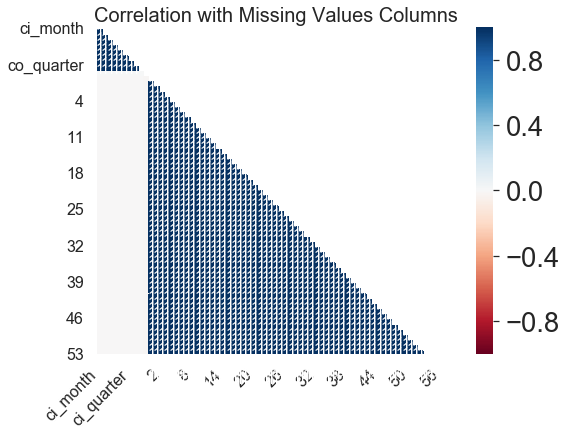

In [118]:
missing_value_columns = train_new_feature.columns[train_new_feature.isnull().any()].tolist()
msno.heatmap(train_new_feature[missing_value_columns], figsize=(8,6))
plt.title("Correlation with Missing Values Columns", fontsize = 20)

- Original feature와 additional feature를 분리해서 correlation 확인

In [125]:
# Correlation between original features
train_new_feature[missing_value_columns[0:10]].corr()

,ci_month,co_month,ci_day,co_day,ci_dayofweek,co_dayofweek,ci_quarter,co_quarter,duration_of_stay,orig_destination_distance
ci_month,1.000000,0.869603,0.084468,0.028120,-0.013048,0.001084,0.969840,0.859258,-0.028702,-0.017584
co_month,0.869603,1.000000,0.012868,0.103580,0.013419,-0.016578,0.860118,0.970398,-0.060120,-0.017047
ci_day,0.084468,0.012868,1.000000,0.445980,0.006615,-0.007494,0.064518,0.002061,-0.011307,-0.017394
co_day,0.028120,0.103580,0.445980,1.000000,0.007686,0.003975,0.018466,0.084777,-0.003729,-0.000332
ci_dayofweek,-0.013048,0.013419,0.006615,0.007686,1.000000,-0.000894,-0.014355,0.007698,-0.014017,-0.053657
co_dayofweek,0.001084,-0.016578,-0.007494,0.003975,-0.000894,1.000000,0.004607,-0.014013,-0.031847,-0.075025
ci_quarter,0.969840,0.860118,0.064518,0.018466,-0.014355,0.004607,1.000000,0.899058,-0.031440,-0.017885
co_quarter,0.859258,0.970398,0.002061,0.084777,0.007698,-0.014013,0.899058,1.000000,-0.056961,-0.015297
duration_of_stay,-0.028702,-0.060120,-0.011307,-0.003729,-0.014017,-0.031847,-0.031440,-0.056961,1.000000,0.219387
orig_destination_distance,-0.017584,-0.017047,-0.017394,-0.000332,-0.053657,-0.075025,-0.017885,-0.015297,0.219387,1.000000


In [126]:
# Correlation between destination features
train_new_feature[missing_value_columns[11:]].corr()

,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
1,1.000000,-0.120397,-0.102616,0.092738,-0.088408,0.061267,-0.009040,0.064875,-0.083029,-0.051489,...,-0.039781,-0.087293,-0.007952,0.110949,0.083336,0.083251,0.001532,0.037015,-0.107411,0.042370
2,-0.120397,1.000000,0.285032,-0.130762,0.045883,-0.075778,0.036489,0.036107,0.219950,-0.043076,...,0.057990,0.085951,-0.018667,-0.138115,-0.090293,0.055397,0.061029,0.050957,0.198203,-0.047987
3,-0.102616,0.285032,1.000000,-0.285195,0.152446,-0.319103,-0.166332,0.092519,0.253883,0.054016,...,0.056904,0.080602,-0.018995,-0.181852,-0.087895,0.005018,0.072441,0.043060,0.149857,0.033138
4,0.092738,-0.130762,-0.285195,1.000000,-0.112762,0.242420,0.067407,0.017225,-0.090973,-0.122342,...,-0.097637,-0.017702,0.043246,0.054251,0.037970,0.034071,-0.036467,0.024057,-0.076863,0.024389
5,-0.088408,0.045883,0.152446,-0.112762,1.000000,-0.136586,-0.038156,0.078463,0.142108,-0.001282,...,0.093077,0.039017,0.065366,-0.113858,-0.033735,-0.015349,0.033003,-0.084494,-0.011956,0.008031
6,0.061267,-0.075778,-0.319103,0.242420,-0.136586,1.000000,0.144357,-0.036848,-0.257903,-0.001839,...,0.006637,0.066410,0.068176,0.115267,0.032031,-0.004590,0.013896,0.004340,-0.084645,-0.146441
7,-0.009040,0.036489,-0.166332,0.067407,-0.038156,0.144357,1.000000,-0.162203,-0.059396,-0.017577,...,-0.081292,-0.095189,-0.125632,-0.036779,-0.037731,-0.006656,-0.064480,0.108930,-0.029011,-0.095742
8,0.064875,0.036107,0.092519,0.017225,0.078463,-0.036848,-0.162203,1.000000,-0.021399,0.174826,...,0.033425,0.118527,0.132938,0.056990,0.075689,0.049595,-0.003277,-0.057008,-0.010434,0.018131
9,-0.083029,0.219950,0.253883,-0.090973,0.142108,-0.257903,-0.059396,-0.021399,1.000000,-0.114864,...,0.011476,-0.072175,-0.130680,-0.164325,-0.203544,0.080317,0.051630,0.046014,0.049547,-0.017434
10,-0.051489,-0.043076,0.054016,-0.122342,-0.001282,-0.001839,-0.017577,0.174826,-0.114864,1.000000,...,0.219201,0.169940,0.117370,-0.093555,0.006670,-0.082034,0.116064,-0.128040,0.064856,-0.008672


- feature 간의 상관관계가 없고, 전체 dataset 중에서 missingvalue가 차지하는 비율이 매우 적음
- missingvalue를 처리하는 여러 방법 중, 제거하는 방법을 선택

In [127]:
train_new_feature[.dropna(inplace=True)

In [128]:
for col in train_new_feature.columns:
    print(col, train_new_feature[col].isnull().sum())

quarter 0
month 0
dayofweek 0
day 0
hour 0
minute 0
ci_month 0
co_month 0
ci_day 0
co_day 0
ci_dayofweek 0
co_dayofweek 0
ci_quarter 0
co_quarter 0
duration_of_stay 0
site_name 0
posa_continent 0
user_location_country 0
user_location_region 0
user_location_city 0
orig_destination_distance 0
user_id 0
is_mobile 0
is_package 0
channel 0
srch_adults_cnt 0
srch_children_cnt 0
srch_rm_cnt 0
srch_destination_id 0
srch_destination_type_id 0
is_booking 0
cnt 0
hotel_continent 0
hotel_country 0
hotel_market 0
hotel_cluster 0
year 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0


In [129]:
train_new_feature.describe()

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,49,50,51,52,53,54,55,56,57,58
count,800865.000000,800865.000000,800865.000000,800865.000000,800865.000000,800865.000000,800865.000000,800865.000000,800865.000000,800865.000000,...,800865.000000,800865.000000,800865.000000,800865.000000,800865.000000,800865.000000,800865.000000,800865.000000,800865.000000,800865.000000
mean,2.678762,7.064198,2.759153,15.806326,13.677873,29.613199,7.116407,6.974826,16.155167,16.047841,...,-0.001096,-0.001076,-0.000300,0.000388,0.000936,0.000024,0.000275,0.000441,0.000184,0.000036
std,1.069159,3.268171,1.983228,8.746897,5.369903,17.304404,3.342508,3.373735,8.835351,8.965832,...,0.017376,0.016601,0.012188,0.010347,0.009991,0.006704,0.006397,0.007084,0.004548,0.002679
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,-0.240996,-0.239794,-0.191948,-0.286081,-0.101886,-0.150592,-0.140328,-0.148481,-0.082778,-0.116686
25%,2.000000,4.000000,1.000000,8.000000,10.000000,15.000000,4.000000,4.000000,9.000000,8.000000,...,-0.001930,-0.002516,-0.001691,-0.003320,-0.002814,-0.000810,-0.000830,-0.000679,-0.000897,-0.000460
50%,3.000000,7.000000,3.000000,16.000000,14.000000,30.000000,7.000000,7.000000,16.000000,16.000000,...,0.000347,-0.000265,-0.000313,0.000986,-0.001038,0.000078,0.000302,0.000096,0.000043,-0.000105
75%,4.000000,10.000000,4.000000,23.000000,18.000000,45.000000,10.000000,10.000000,24.000000,24.000000,...,0.001636,0.001327,0.003148,0.002839,0.002386,0.001593,0.002058,0.001955,0.001752,0.000306
max,4.000000,12.000000,6.000000,31.000000,23.000000,59.000000,12.000000,12.000000,31.000000,31.000000,...,0.193601,0.211433,0.174185,0.138820,0.210800,0.113351,0.157033,0.178027,0.195901,0.203099
